# SWOT gradient & interpolation

In [1]:
import os
from glob import glob
import threading

import xarray as xr
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from pyproj import Geod

import pynsitu as pyn
crs = pyn.maps.crs

In [2]:
zarr = "/home/datawork-lops-osi/aponte/swot/cswot/swot/l3_v1.0.1/3_500.zarr"
ds = xr.open_zarr(zarr)
ds

<xarray.Dataset>
Dimensions:                                  (num_lines: 4161, num_pixels: 519)
Coordinates:
    latitude                                 (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    longitude                                (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/36)
    ancillary_surface_classification_flag    (num_lines, num_pixels) float32 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cross_track_distance                     (num_lines, num_pixels) float32 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cvl_dac                                  (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cvl_distance_to_coast                    (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cvl_flag_val                             (num_lines, num_pixels) float32 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cvl_ice_conc                             (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    ...                                       ...
    pass_number                              (num_lines) uint16 dask.array<chunksize=(4161,), meta=np.ndarray>
    sig0_karin_2                             (num_lines, num_pixels) float32 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    ssh_karin_2_qual                         (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    time                                     (num_lines) datetime64[ns] dask.array<chunksize=(4161,), meta=np.ndarray>
    time_tai                                 (num_lines) datetime64[ns] dask.array<chunksize=(4161,), meta=np.ndarray>
    version                                  (num_lines) |S7 dask.array<chunksize=(4161,), meta=np.ndarray>
Attributes:
    latc:     39.961324
    lonc:     4.3749
    phi:      76.80931729750102

In [3]:
# get grid orientation and metrics

def add_grid_metrics(ds):
    """ add grid spatial metrics """

    geod = Geod(ellps="WGS84")

    lon, lat = ds.longitude, ds.latitude
    dims = lon.dims
    
    # d/dx where x is cross-track
    az12, az21, dx = geod.inv(
        lon, lat, lon.shift(num_pixels=-1), lat.shift(num_pixels=-1),
    )
    
    ds = ds.assign_coords(dx=(dims, dx), phi=(dims, az12*np.pi/180))
    
    ds["dx"] = (
        ds["dx"]
        .ffill("num_pixels")
        .where(ds["duacs_editing_flag"]<5)
    )

    # phi is cross-track direction from north
    ds["phi"] = (
        ds["phi"]
        .ffill("num_pixels")
        .where(ds["duacs_editing_flag"]<5)
    )

    # d/dy where y is along-track
    
    az12, az21, dy = geod.inv(
        lon, lat, lon.shift(num_lines=-1), lat.shift(num_lines=-1),
    )
    
    ds = ds.assign_coords(dy=(dims, dy))
    
    ds["dy"] = (
        ds["dy"]
        .ffill("num_lines")
        .where(ds["duacs_editing_flag"]<5)
    )
    
    return ds

ds = add_grid_metrics(ds)

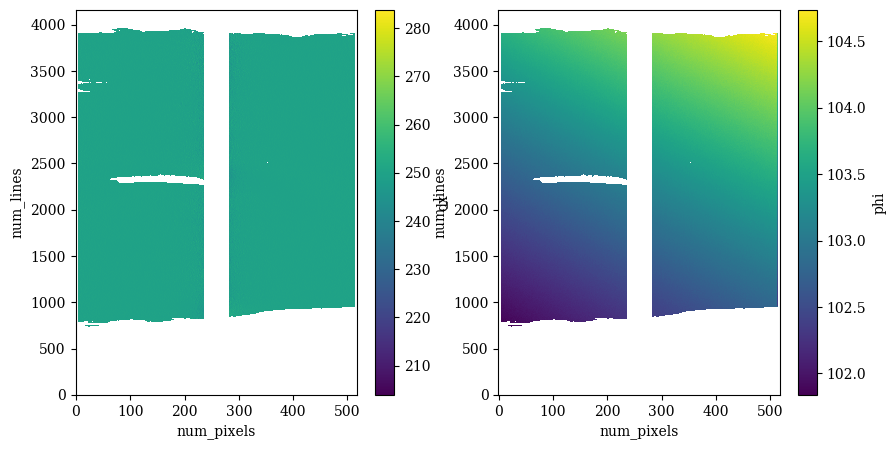

In [4]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
ds["dx"].plot(ax=axes[0])
(ds["phi"]*180/np.pi).plot(ax=axes[1])

In [5]:
ds["dx"].mean().compute(), ds["dx"].std().compute()

(<xarray.DataArray 'dx' ()>
 array(249.88069072),
 <xarray.DataArray 'dx' ()>
 array(0.55453346))

In [6]:
0.5/250

0.002

## gradient

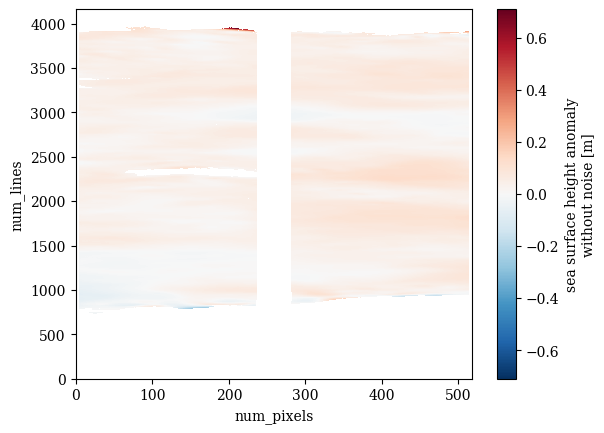

In [64]:
da = ds.duacs_ssha_karin_2_filtered

# handle NaNs to mitigate propagation
#da = da.fillna(0.)
# or interpolate with da.interpolate_na

da.plot()

In [65]:
# "naive" approach, noise will have an impact
dx = 250 # meters
da_dx = da.differentiate("num_pixels")/dx

In [66]:
from scipy.ndimage import gaussian_filter
gaussian_filter?

Signature:
gaussian_filter(
    input,
    sigma,
    order=0,
    output=None,
    mode='reflect',
    cval=0.0,
    truncate=4.0,
    *,
    radius=None,
    axes=None,
)
Docstring:
Multidimensional Gaussian filter.

Parameters
----------
input : array_like
    The input array.
sigma : scalar or sequence of scalars
    Standard deviation for Gaussian kernel. The standard
    deviations of the Gaussian filter are given for each axis as a
    sequence, or as a single number, in which case it is equal for
    all axes.
order : int or sequence of ints, optional
    The order of the filter along each axis is given as a sequence
    of integers, or as a single number. An order of 0 corresponds
    to convolution with a Gaussian kernel. A positive order
    corresponds to convolution with that derivative of a Gaussian.
output : array or dtype, optional
    The array in which to place the output, or the dtype of the
    returned array. By default an array of the same dtype as input
    will 

In [67]:
# gaussian derivative

def gradient_gauss(da, cutoff = 1e3, dx = 250, **kwargs):

    # cross-track
    i = da.get_axis_num("num_pixels")
    order = [0,0]
    order[i] = 1
    da_dx_gauss = xr.DataArray(gaussian_filter(da, sigma=cutoff/dx, order=order, **kwargs), dims=da.dims) /dx
    #da_dx = da_dx.where(da)
    
    # cross-track
    i = da.get_axis_num("num_lines")
    order = [0,0]
    order[i] = 1
    da_dy_gauss = xr.DataArray(gaussian_filter(da, sigma=cutoff/dx, order=order, **kwargs), dims=da.dims) /dx
    #da_dx = da_dx.where(da)

    return da_dx_gauss, da_dy_gauss


da_dx_gauss, da_dy_gauss = gradient_gauss(da)
da_dx_gaussb, da_dy_gaussb = gradient_gauss(da, cutoff=5e3, truncate=2.)

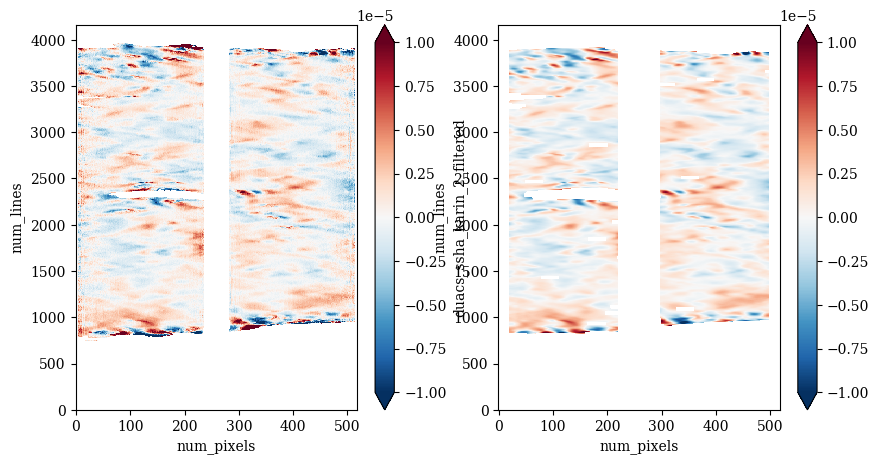

In [68]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

ax = axes[0]
da_dx.plot(ax=ax, vmax=1e-5)

ax = axes[1]
da_dx_gauss.plot(ax=ax, vmax=1e-5)

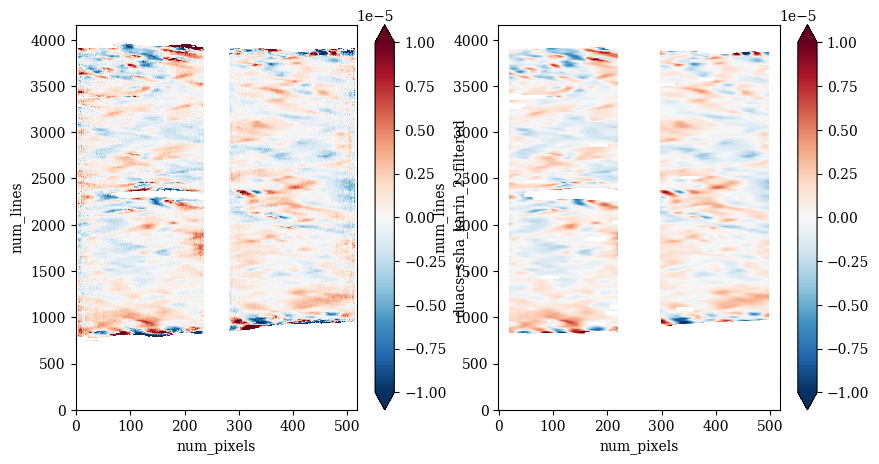

In [69]:
# if NaN filled

fig, axes = plt.subplots(1,2,figsize=(10,5))

ax = axes[0]
da_dx.plot(ax=ax, vmax=1e-5)

ax = axes[1]
da_dx_gauss.where(da).plot(ax=ax, vmax=1e-5)

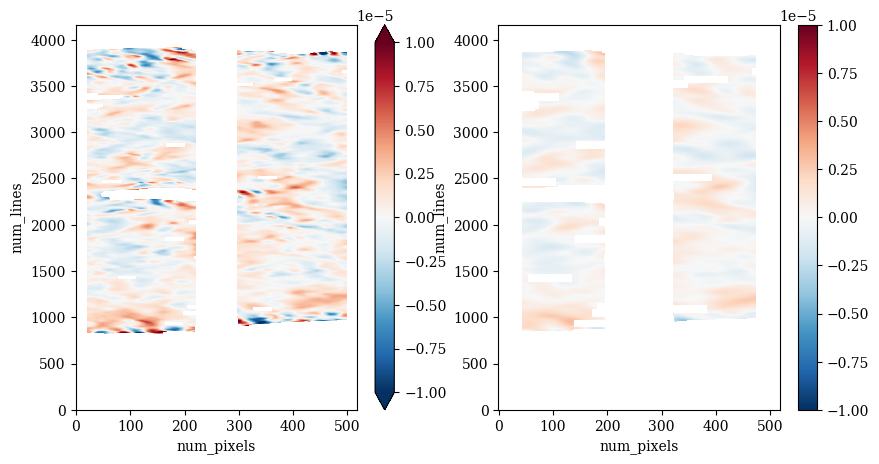

In [70]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

ax = axes[0]
da_dx_gauss.plot(ax=ax, vmax=1e-5)

ax = axes[1]
da_dx_gaussb.plot(ax=ax, vmax=1e-5)

## interpolation

2 choices: [pyinterp](https://pangeo-pyinterp.readthedocs.io/en/latest/auto_examples/ex_unstructured.html) or [xESMF](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Using_LocStream.html)

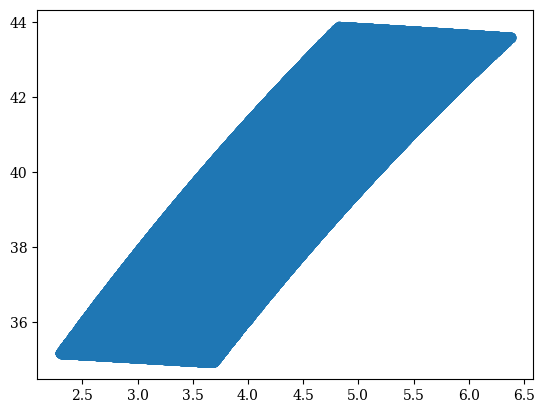

In [71]:
fig, ax = plt.subplots(1,1)
ax.scatter(ds.longitude, ds.latitude)

In [72]:
t = np.arange(0,100)/100*2*np.pi
dr = xr.Dataset( dict(longitude=("t", 5. + 1*np.cos(t)), latitude=("t", 41 + np.sin(t)) ))

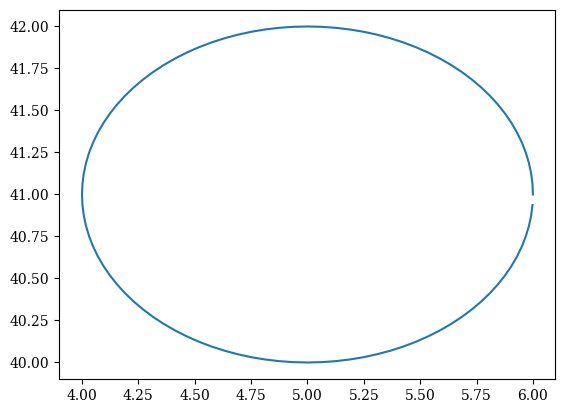

In [73]:
plt.plot(dr.longitude, dr.latitude)

In [74]:
dr

<xarray.Dataset>
Dimensions:    (t: 100)
Dimensions without coordinates: t
Data variables:
    longitude  (t) float64 6.0 5.998 5.992 5.982 ... 5.969 5.982 5.992 5.998
    latitude   (t) float64 41.0 41.06 41.13 41.19 ... 40.75 40.81 40.87 40.94

In [75]:
import pyinterp
mesh = pyinterp.RTree()

In [76]:
lons = ds.longitude.compute().data.flatten()
lats = ds.latitude.compute().data.flatten()
data = da_dx_gauss.compute().data.flatten()

mesh.packing(np.vstack((lons, lats)).T, data)
mx = dr.longitude.data
my = dr.latitude.data

idw, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.ravel(), my.ravel())).T,
    within=False,  # Extrapolation is forbidden
    k=5,  # We are looking for at most 11 neighbors
    num_threads=0,
)
idw = idw.reshape(mx.shape)

dr["deta_dx"] = (dr.longitude.dims, idw)

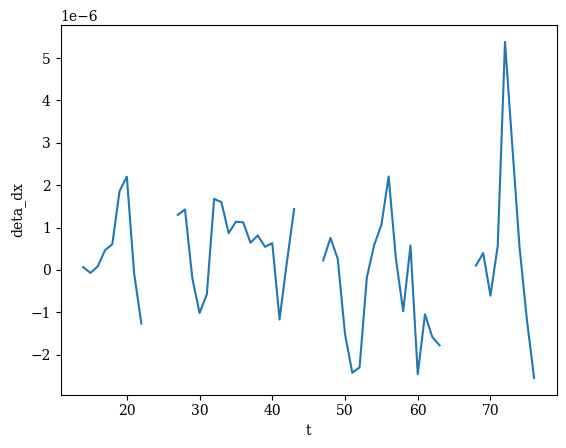

In [77]:
dr["deta_dx"].plot()

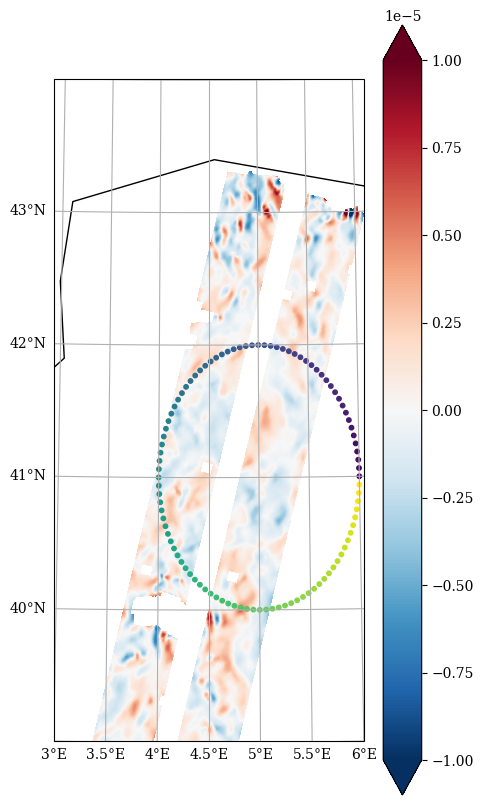

In [83]:
fig, ax, _ = pyn.maps.plot_map(extent=[3, 6, 39, 44], figsize=(5,10))
da_dx_gauss.assign_coords(**ds.coords).plot(x="longitude", y="latitude", vmax=1e-5, transform=crs)
ax.scatter(dr.longitude, dr.latitude, s=10, c=dr.t, transform=crs)

### xESMF

In [84]:
import xesmf as xe

In [86]:
ds.rename(longitude="lon", latitude="lat")

<xarray.Dataset>
Dimensions:                                  (num_lines: 4161, num_pixels: 519)
Coordinates:
    lat                                      (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    lon                                      (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    dx                                       (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    phi                                      (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    dy                                       (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/36)
    ancillary_surface_classification_flag    (num_lines, num_pixels) float32 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cross_track_distance                     (num_lines, num_pixels) float32 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cvl_dac                                  (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cvl_distance_to_coast                    (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cvl_flag_val                             (num_lines, num_pixels) float32 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    cvl_ice_conc                             (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    ...                                       ...
    pass_number                              (num_lines) uint16 dask.array<chunksize=(4161,), meta=np.ndarray>
    sig0_karin_2                             (num_lines, num_pixels) float32 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    ssh_karin_2_qual                         (num_lines, num_pixels) float64 dask.array<chunksize=(4161, 519), meta=np.ndarray>
    time                                     (num_lines) datetime64[ns] dask.array<chunksize=(4161,), meta=np.ndarray>
    time_tai                                 (num_lines) datetime64[ns] dask.array<chunksize=(4161,), meta=np.ndarray>
    version                                  (num_lines) |S7 dask.array<chunksize=(4161,), meta=np.ndarray>
Attributes:
    latc:     39.961324
    lonc:     4.3749
    phi:      76.80931729750102

In [93]:
_ds = ds.rename(longitude="lon", latitude="lat")
_dr = dr.rename(longitude="lon", latitude="lat")
regridder = xe.Regridder(_ds, _dr, "bilinear", locstream_out=True)
da_dx_out = regridder(da_dx_gauss)

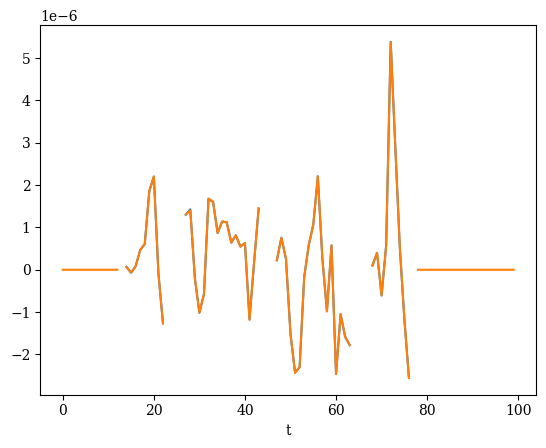

In [97]:
dr["deta_dx"].plot()
da_dx_out.plot()